# Temperature and humidity calibration - Regression analysis

In [1]:
# to access the data on google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import matplotlib.dates as mdates
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

import statsmodels.api as sm

# Position of the Lamps and Sensors

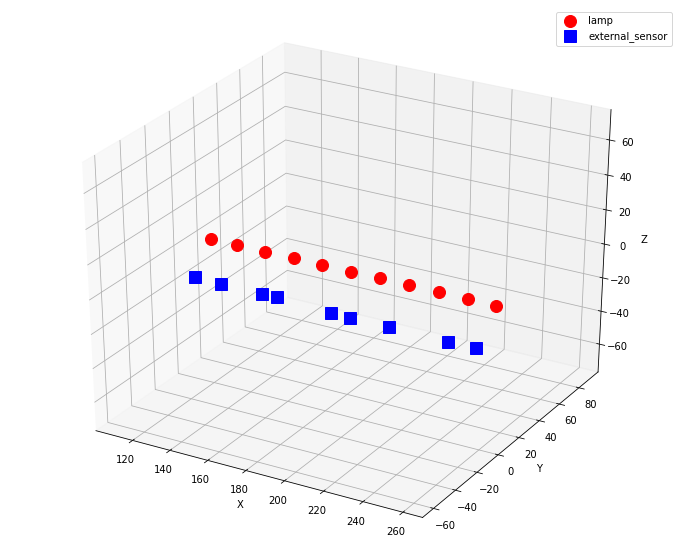

In [3]:
dfmeta = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/raw/metadata.csv")

# the position of the lamps and sensors in the experiment (3D)

fig3d = plt.figure(figsize=(12,10))
ax = plt.axes(projection="3d")

x = dfmeta["x_position"][dfmeta["device_type"]=="lamp"]
y = dfmeta["y_position"][dfmeta["device_type"]=="lamp"]
z = dfmeta["z_position"][dfmeta["device_type"]=="lamp"]

x2 = dfmeta["x_position"][dfmeta["device_type"]=="external_sensor"]
y2 = dfmeta["y_position"][dfmeta["device_type"]=="external_sensor"]
z2 = dfmeta["z_position"][dfmeta["device_type"]=="external_sensor"]

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.plot(x, y, z, marker="o", linestyle="", color="red", ms=12, label="lamp")
ax.plot(x2, y2, z2, marker="s", linestyle="", color="blue", ms=12, label="external_sensor")
ax.legend()

# make the grid of all x-, y-, and z-axes have equal distance
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], "w")

# plt.savefig("/content/drive/MyDrive/propulsion/Final_Project/3Dposition.jpg", facecolor="w")

plt.grid()
plt.show()

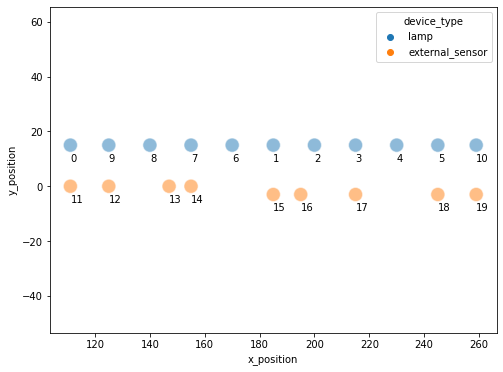

In [4]:
# the position of the lamps and sensors in the experiment (2D)

fig2d = plt.figure(figsize=(8,6))
sns.scatterplot(data=dfmeta, x="x_position", y="y_position", hue="device_type", s=200, alpha=0.5)
for mark in range(0, dfmeta.shape[0]):
    plt.text(dfmeta["x_position"][mark], dfmeta["y_position"][mark] - 6, dfmeta.index[mark])
plt.axis("equal")

# plt.savefig("/content/drive/MyDrive/propulsion/Final_Project/2Dposition.jpg", facecolor="w")

plt.show()

In [5]:
dfmeta

source_address  x_position  y_position  z_position      device_type
0       2062404276         111          15           0             lamp
1        367818600         185          15           0             lamp
2       1307336718         200          15           0             lamp
3       2050868026         215          15           0             lamp
4        160784073         230          15           0             lamp
5        465407368         245          15           0             lamp
6        730804714         170          15           0             lamp
7       1629094469         155          15           0             lamp
8        924241205         140          15           0             lamp
9        362609437         125          15           0             lamp
10       856134660         259          15           0             lamp
11      1916751226         111           0         -16  external_sensor
12       614953587         125           0         -16  external_sensor
13      1012045058         147           0         -16  external_sensor
14      1566931549         155           0         -16  external_sensor
15      2132706098         185          -3         -16  external_sensor
16      1815204248         195          -3         -16  external_sensor
17      2099571705         215          -3         -16  external_sensor
18       926036168         245          -3         -16  external_sensor
19      1786944289         259          -3         -16  external_sensor

# Load Dataset and Basic Cleaning 

In [6]:
# define a function to split the dataset into one with lamps and the other with sensors
def device_split(dataf):
    # change the type of source_address to categorical
    dataf["source_address"] = dataf["source_address"].astype("category")

    dflamp = dataf[dataf["device_type"]=="lamp"]
    # keep only the columns that are nonmissing and not a constant
    dflamp_c = dflamp.drop(["shtc3_humidity", "shtc3_temperature", "y_position", "z_position", "device_type"], axis=1).sort_values(["time", "source_address"], ascending=True)

    # drop data error (the rows with negative values from energy or detect per period)
    dflamp_d = dflamp_c[(dflamp_c["energy_per_period"]>=0) & (dflamp_c["detect_per_period"]>=0)]

    dfsensor = dataf[dataf["device_type"]=="external_sensor"]
    # keep only the columns that are nonmissing
    dfsensor_c = dfsensor[["time", "source_address", "shtc3_humidity", "shtc3_temperature", "x_position"]].sort_values(["time", "source_address"], ascending=True)

    return dflamp_d, dfsensor_c

In [7]:
df_raw = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/processed/LEDcity_merged_data.csv", parse_dates=["time"])
dfadd_raw = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/processed/LEDcity_merged_data_add.csv", parse_dates=["time"])

In [8]:
dflamp, dfsensor = device_split(df_raw)
dflamp2, dfsensor2 = device_split(dfadd_raw)

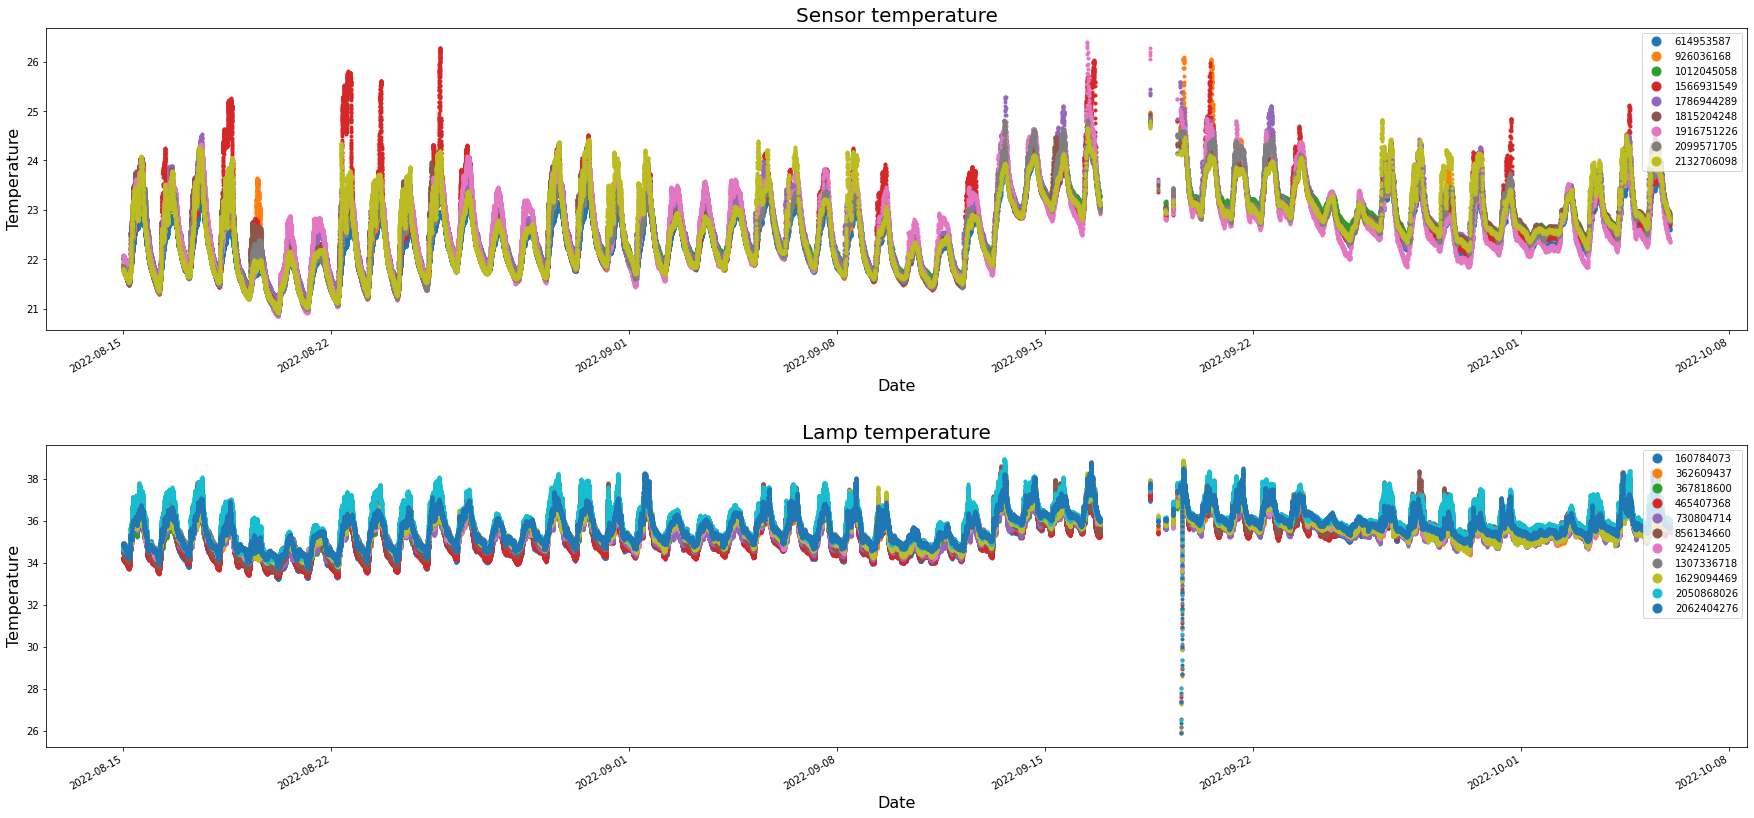

In [9]:
# generate a dummy variable to capture whether a reading is on a weekend# examine irregular temperature reading in sensors in lamps from the initial dataset
dfsensor["source_address"] = dfsensor["source_address"].cat.remove_unused_categories()
dflamp["source_address"] = dflamp["source_address"].cat.remove_unused_categories()

fig, ax = plt.subplots(2, 1, figsize=(25,12))
dfsensor.groupby("source_address").plot(x="time", y="shtc3_temperature", marker=".", linestyle="", ax=ax[0])
ax[0].legend([v[0] for v in dfsensor.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[0].set_title("Sensor temperature", size=20)
ax[0].set_xlabel("Date", size=16)
ax[0].set_ylabel("Temperature", size=16)
dflamp.groupby("source_address").plot(x="time", y="sht40_temperature", marker=".", linestyle="", ax=ax[1])
ax[1].legend([v[0] for v in dflamp.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[1].set_title("Lamp temperature", size=20)
ax[1].set_xlabel("Date", size=16)
ax[1].set_ylabel("Temperature", size=16)

plt.tight_layout(pad=3.0)
plt.show()

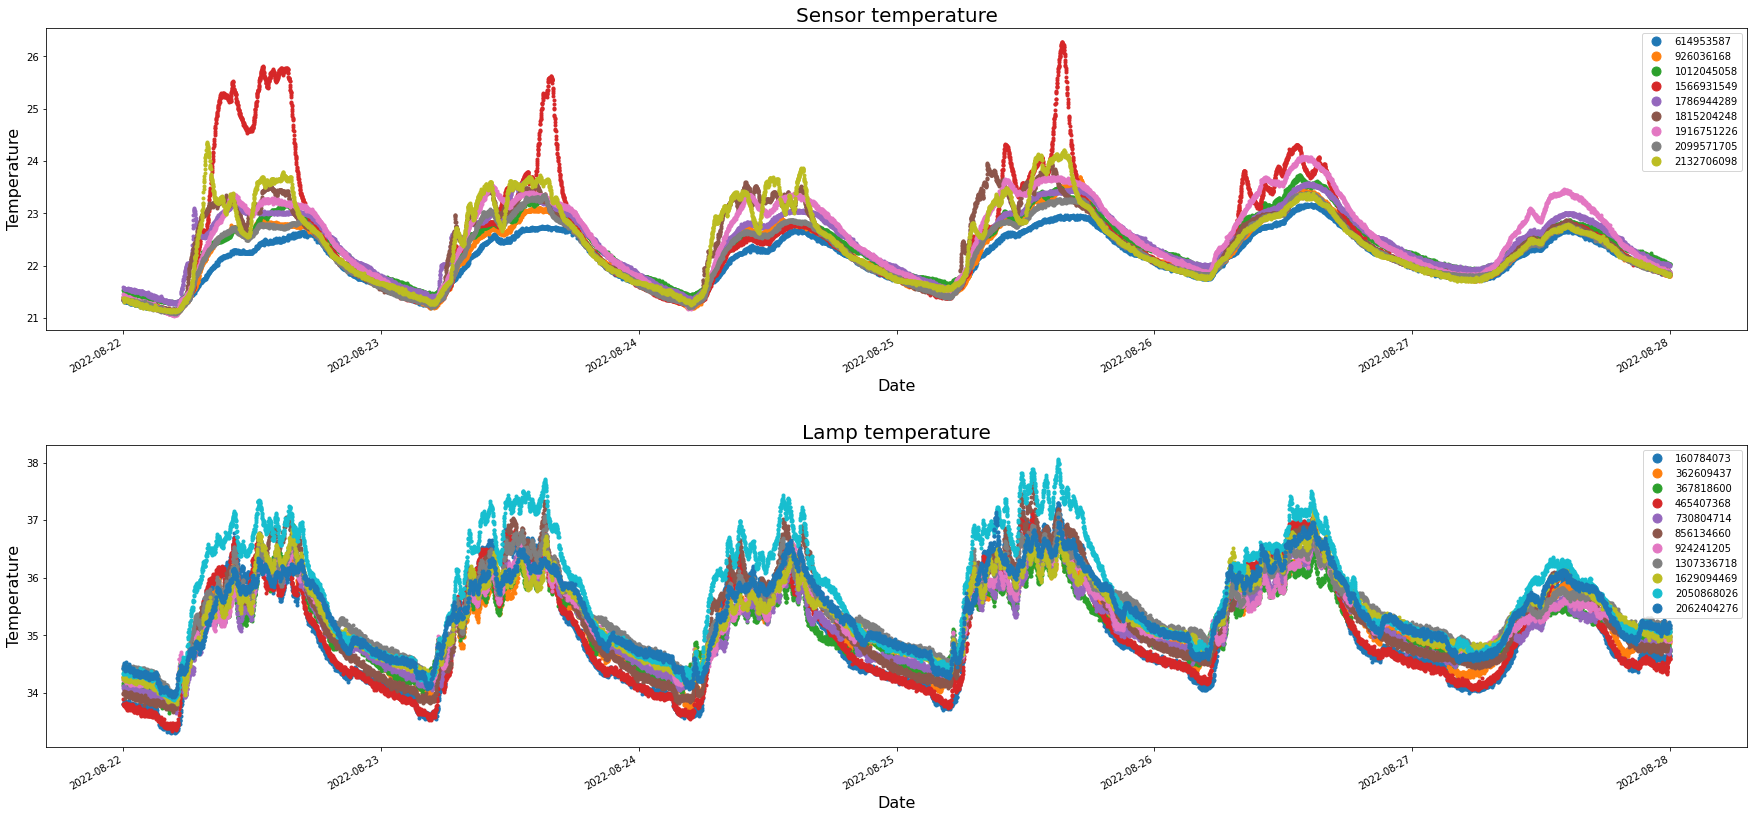

In [10]:
# examine irregular temperature reading in sensors in lamps from the initial dataset (from 22/08 to 28/08)
dfsensor_part = dfsensor[(dfsensor["time"] >= "2022-08-22") & (dfsensor["time"] <= "2022-08-28")]
dflamp_part = dflamp[(dflamp["time"] >= "2022-08-22") & (dflamp["time"] <= "2022-08-28")]

fig, ax = plt.subplots(2, 1, figsize=(25,12))
dfsensor_part.groupby("source_address").plot(x="time", y="shtc3_temperature", marker=".", linestyle="", ax=ax[0])
ax[0].legend([v[0] for v in dfsensor.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[0].set_title("Sensor temperature", size=20)
ax[0].set_xlabel("Date", size=16)
ax[0].set_ylabel("Temperature", size=16)
dflamp_part.groupby("source_address").plot(x="time", y="sht40_temperature", marker=".", linestyle="", ax=ax[1])
ax[1].legend([v[0] for v in dflamp.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[1].set_title("Lamp temperature", size=20)
ax[1].set_xlabel("Date", size=16)
ax[1].set_ylabel("Temperature", size=16)

### plt.savefig("/content/drive/MyDrive/propulsion/Final_Project/temp_date.jpg", facecolor="w") # the default when copying/saving the figure turns the facecolor into black and cannot see the axes
plt.tight_layout(pad=3.0)
plt.show()


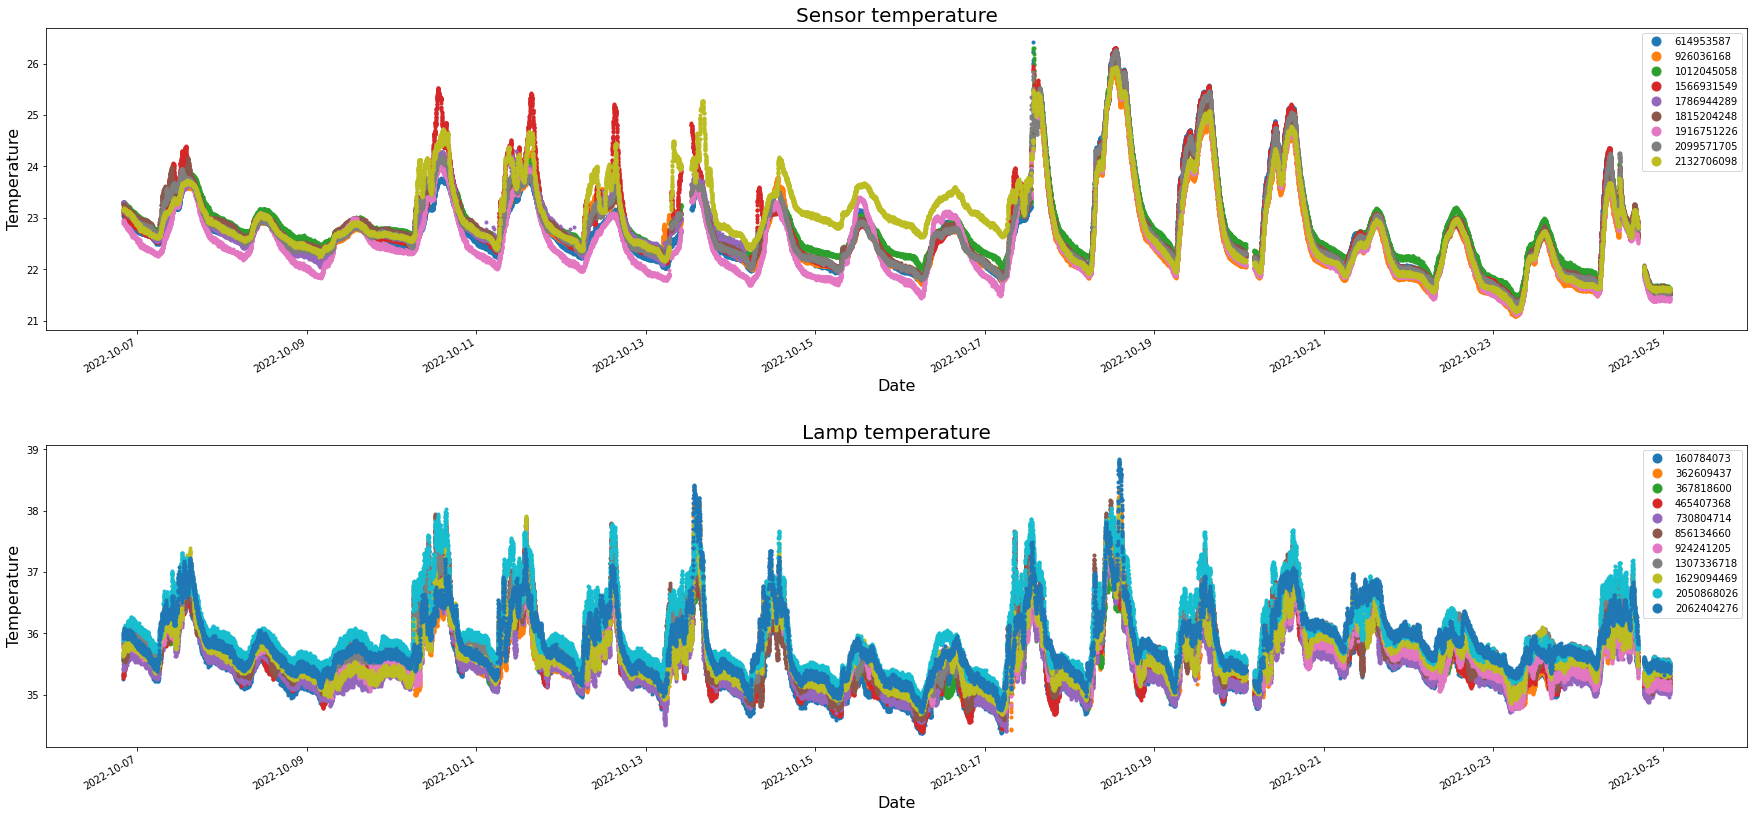

In [11]:
# examine irregular temperature reading in sensors in lamps from the second dataset
dfsensor2["source_address"] = dfsensor2["source_address"].cat.remove_unused_categories()
dflamp2["source_address"] = dflamp2["source_address"].cat.remove_unused_categories()

fig, ax = plt.subplots(2, 1, figsize=(25,12))
dfsensor2.groupby("source_address").plot(x="time", y="shtc3_temperature", marker=".", linestyle="", ax=ax[0])
ax[0].legend([v[0] for v in dfsensor2.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[0].set_title("Sensor temperature", size=20)
ax[0].set_xlabel("Date", size=16)
ax[0].set_ylabel("Temperature", size=16)
dflamp2.groupby("source_address").plot(x="time", y="sht40_temperature", marker=".", linestyle="", ax=ax[1])
ax[1].legend([v[0] for v in dflamp2.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[1].set_title("Lamp temperature", size=20)
ax[1].set_xlabel("Date", size=16)
ax[1].set_ylabel("Temperature", size=16)

plt.tight_layout(pad=3.0)
plt.show()

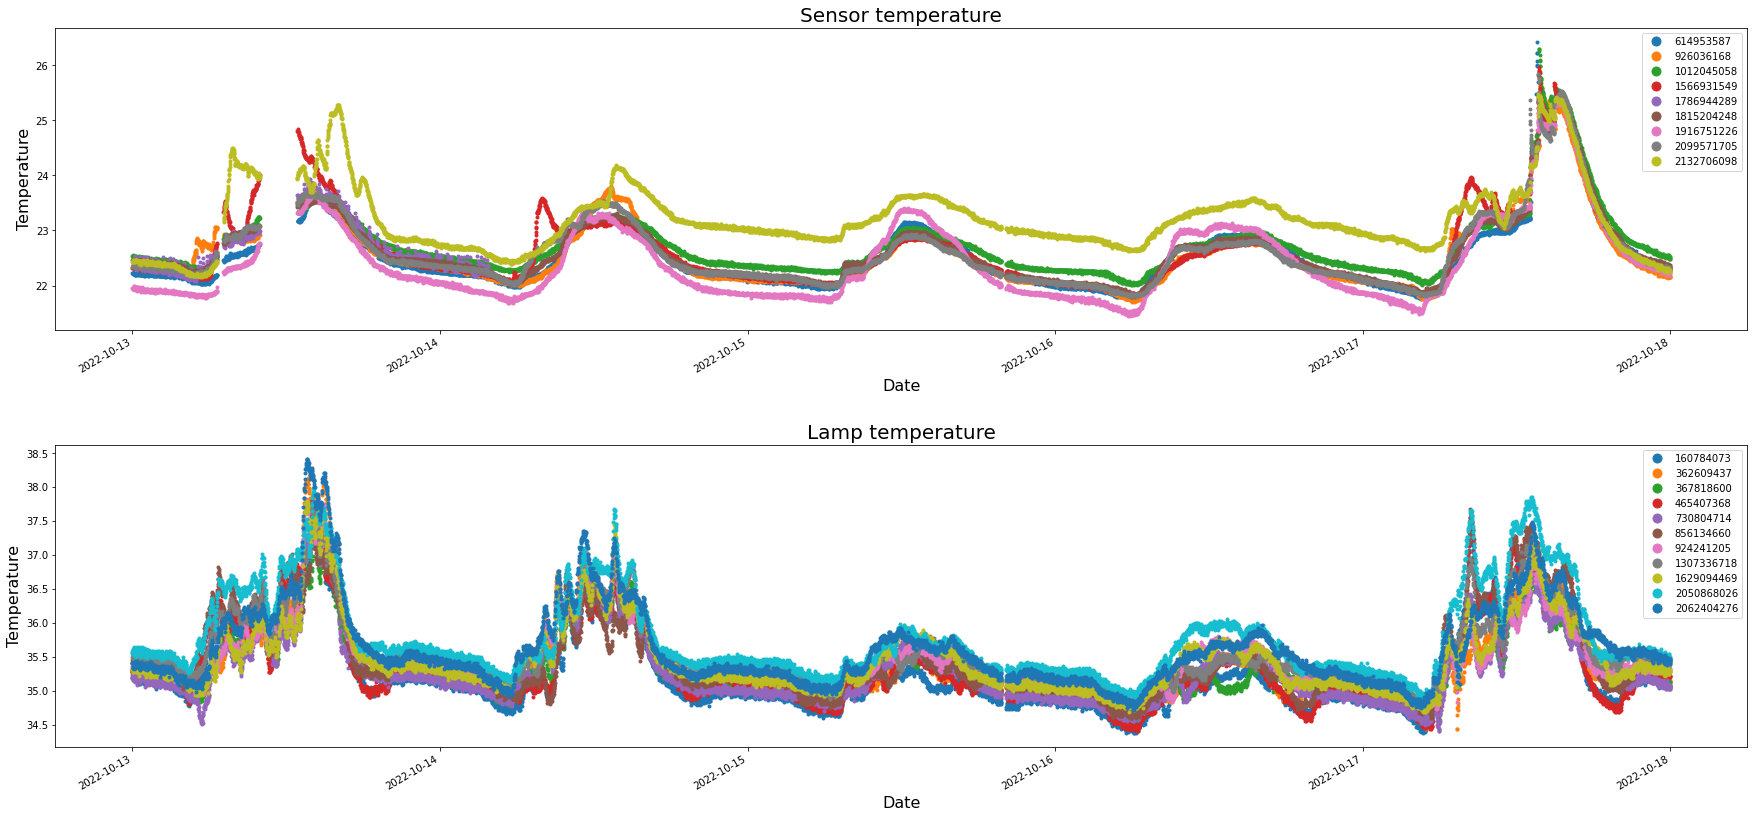

In [12]:
# examine irregular temperature reading in sensors in lamps from the second dataset (from 13/10 to 18/10)
dfsensor2_part = dfsensor2[(dfsensor2["time"] >= "2022-10-13") & (dfsensor2["time"] <= "2022-10-18")]
dflamp2_part = dflamp2[(dflamp2["time"] >= "2022-10-13") & (dflamp2["time"] <= "2022-10-18")]

fig, ax = plt.subplots(2, 1, figsize=(25,12))
dfsensor2_part.groupby("source_address").plot(x="time", y="shtc3_temperature", marker=".", linestyle="", ax=ax[0])
ax[0].legend([v[0] for v in dfsensor2.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[0].set_title("Sensor temperature", size=20)
ax[0].set_xlabel("Date", size=16)
ax[0].set_ylabel("Temperature", size=16)
dflamp2_part.groupby("source_address").plot(x="time", y="sht40_temperature", marker=".", linestyle="", ax=ax[1])
ax[1].legend([v[0] for v in dflamp2.groupby("source_address")["source_address"]], loc="upper right", markerscale=3)
ax[1].set_title("Lamp temperature", size=20)
ax[1].set_xlabel("Date", size=16)
ax[1].set_ylabel("Temperature", size=16)

### plt.savefig("/content/drive/MyDrive/propulsion/Final_Project/temp_date.jpg", facecolor="w") # the default when copying/saving the figure turns the facecolor into black and cannot see the axes
plt.tight_layout(pad=3.0)
plt.show()

# Match lamp with nearest sensor reading recorded within 5 seconds

In [13]:
# converting time to the index so we can preserve the time columns and verify the merge has been done properly
dflamp.index = dflamp["time"]
dfsensor.index = dfsensor["time"]

# specify the range of tolerance for the merge (in this case 1 second)
margin = pd.Timedelta(seconds=5)
dfmerge = pd.merge_asof(left=dflamp, right=dfsensor, right_index=True, left_index=True, direction="nearest", tolerance=margin)

In [14]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803261 entries, 2022-08-15 00:01:48.831000 to 2022-10-05 23:59:11.463000
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   time_x                   803261 non-null  datetime64[ns]
 1   source_address_x         803261 non-null  category      
 2   light_state              803261 non-null  float64       
 3   local_detections         803261 non-null  float64       
 4   sht40_humidity           803261 non-null  float64       
 5   sht40_temperature        803261 non-null  float64       
 6   total_normalized_energy  803261 non-null  float64       
 7   wsen_pads_temperature    803261 non-null  float64       
 8   x_position_x             803261 non-null  int64         
 9   energy_per_period        803261 non-null  float64       
 10  detect_per_period        803261 non-null  float64       
 11  time_diff                80326

In [15]:
dfsec = dfmerge.dropna().reset_index(drop=True)

In [16]:
dfsec

time_x source_address_x  light_state  \
0      2022-08-15 00:01:48.831        856134660          2.0   
1      2022-08-15 00:01:48.858       2050868026          2.0   
2      2022-08-15 00:01:48.861       1629094469          2.0   
3      2022-08-15 00:01:48.869        730804714          2.0   
4      2022-08-15 00:01:48.872        160784073          2.0   
...                        ...              ...          ...   
409033 2022-10-05 23:58:11.433        367818600          2.0   
409034 2022-10-05 23:58:11.434        160784073          2.0   
409035 2022-10-05 23:58:11.436        465407368          2.0   
409036 2022-10-05 23:58:11.437       2050868026          2.0   
409037 2022-10-05 23:58:11.450        924241205          2.0   

        local_detections  sht40_humidity  sht40_temperature  \
0                13815.0           25.59              34.50   
1                17776.0           25.55              34.74   
2                15988.0           25.62              34.78   
3                24510.0           26.13              34.49   
4                23565.0           25.81              34.14   
...                  ...             ...                ...   
409033           27551.0           24.47              35.57   
409034           33783.0           23.64              35.56   
409035           23750.0           25.09              35.69   
409036           23860.0           23.76              36.01   
409037           19539.0           24.42              35.54   

        total_normalized_energy  wsen_pads_temperature  x_position_x  \
0                      173679.0                  34.71           259   
1                      226070.0                  34.62           215   
2                      167885.0                  34.70           155   
3                      250216.0                  34.86           170   
4                      219515.0                  34.43           230   
...                         ...                    ...           ...   
409033                 352791.0                  35.78           185   
409034                 315182.0                  35.79           230   
409035                 278181.0                  35.81           245   
409036                 324802.0                  35.79           215   
409037                 281287.0                  36.37           140   

        energy_per_period  detect_per_period  time_diff  power  \
0                     0.0                0.0       59.0    1.5   
1                     0.0                0.0       60.0    1.5   
2                     0.0                0.0       60.0    1.5   
3                     0.0                0.0       60.0    1.5   
4                     0.0                0.0       60.0    1.5   
...                   ...                ...        ...    ...   
409033                0.0                0.0       60.0    1.5   
409034                0.0                0.0       60.0    1.5   
409035                0.0                0.0       60.0    1.5   
409036                0.0                0.0       60.0    1.5   
409037                0.0                0.0       60.0    1.5   

                        time_y source_address_y  shtc3_humidity  \
0      2022-08-15 00:01:50.770       1815204248           49.83   
1      2022-08-15 00:01:50.770       1815204248           49.83   
2      2022-08-15 00:01:50.770       1815204248           49.83   
3      2022-08-15 00:01:50.770       1815204248           49.83   
4      2022-08-15 00:01:50.770       1815204248           49.83   
...                        ...              ...             ...   
409033 2022-10-05 23:58:07.567       2099571705           45.73   
409034 2022-10-05 23:58:07.567       2099571705           45.73   
409035 2022-10-05 23:58:07.567       2099571705           45.73   
409036 2022-10-05 23:58:07.567       2099571705           45.73   
409037 2022-10-05 23:58:07.567       2099571705           45.73   

        shtc3_temperature  x_positi

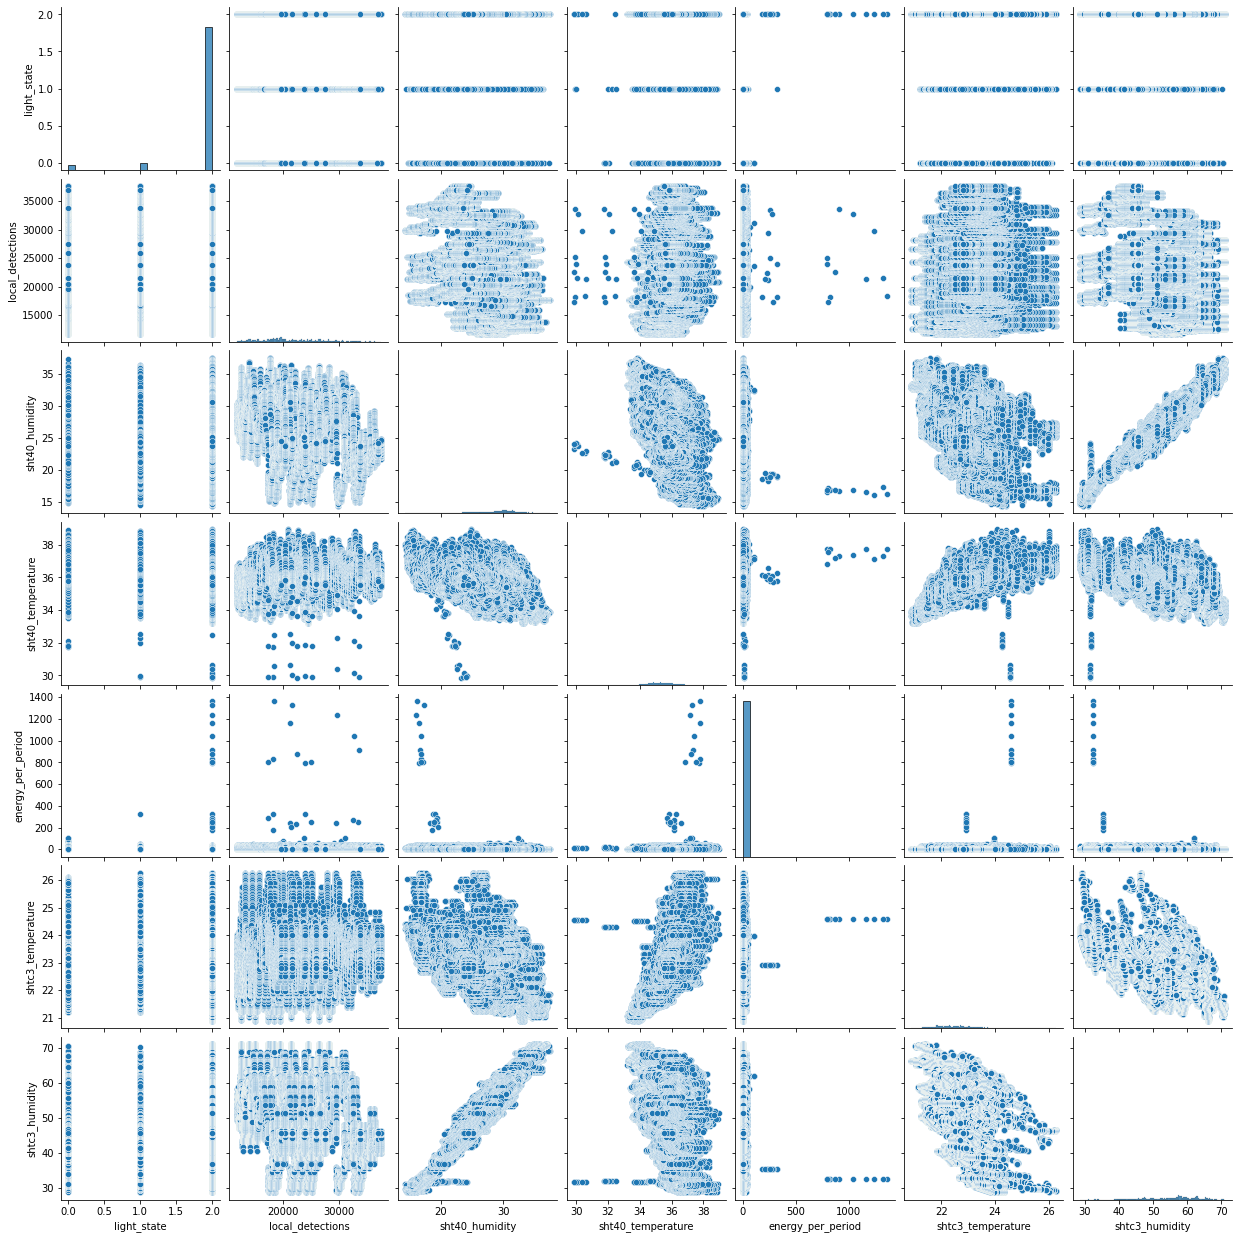

In [17]:
sns.pairplot(dfsec[["light_state", "local_detections", "sht40_humidity", "sht40_temperature", "energy_per_period", "shtc3_temperature", "shtc3_humidity"]])

# Match lamp with nearest sensor in location and recorded at most 5 seconds after

In [18]:
# create dictionary representing the pairing of lamp with nearest sensor in location
dict_ls = {
    dfmeta["source_address"][0]: dfmeta["source_address"][11],
    dfmeta["source_address"][9]: dfmeta["source_address"][12],
    dfmeta["source_address"][8]: dfmeta["source_address"][13],
    dfmeta["source_address"][7]: dfmeta["source_address"][13],
    dfmeta["source_address"][6]: dfmeta["source_address"][15],
    dfmeta["source_address"][1]: dfmeta["source_address"][15],
    dfmeta["source_address"][2]: dfmeta["source_address"][16],
    dfmeta["source_address"][3]: dfmeta["source_address"][17],
    dfmeta["source_address"][4]: dfmeta["source_address"][18],
    dfmeta["source_address"][5]: dfmeta["source_address"][18],
    dfmeta["source_address"][10]: dfmeta["source_address"][19]
}

In [19]:
# define a function to match the lamp with corresponding sensor
def match_ls(df1, df2, marg):
    listfull = []
    for l in range(0, len(dict_ls)):
        df1p = df1[df1["source_address"]==list(dict_ls)[l]]
        df2p = df2[df2["source_address"]==dict_ls[list(dict_ls)[l]]]
        # specify the range of tolerance for the merge (in this case 1 second)
        margin = pd.Timedelta(seconds=marg)
        dfm = pd.merge_asof(left=df1p, right=df2p, right_index=True, left_index=True, direction="forward", tolerance=margin)
        dfpart = dfm.dropna()
        listfull.append(dfpart)
    dffull = pd.concat(listfull)
    return dffull

In [20]:
# run the lamp-sensor match function
d1 = dflamp
d2 = dfsensor
m = 5

dfmatch = match_ls(d1, d2, m)

In [21]:
dfmatch

time_x source_address_x  light_state  \
time                                                                            
2022-08-15 05:40:51.143 2022-08-15 05:40:51.143       2062404276          1.0   
2022-08-15 05:41:51.139 2022-08-15 05:41:51.139       2062404276          1.0   
2022-08-15 05:42:51.151 2022-08-15 05:42:51.151       2062404276          2.0   
2022-08-15 05:43:51.163 2022-08-15 05:43:51.163       2062404276          1.0   
2022-08-15 05:44:51.163 2022-08-15 05:44:51.163       2062404276          2.0   
...                                         ...              ...          ...   
2022-10-04 15:09:53.728 2022-10-04 15:09:53.728        856134660          1.0   
2022-10-04 15:14:53.775 2022-10-04 15:14:53.775        856134660          0.0   
2022-10-04 21:10:43.383 2022-10-04 21:10:43.383        856134660          2.0   
2022-10-05 23:05:48.051 2022-10-05 23:05:48.051        856134660          2.0   
2022-10-05 23:35:50.843 2022-10-05 23:35:50.843        856134660          2.0   

                         local_detections  sht40_humidity  sht40_temperature  \
time                                                                           
2022-08-15 05:40:51.143           18575.0           30.27              35.10   
2022-08-15 05:41:51.139           18577.0           30.08              35.25   
2022-08-15 05:42:51.151           18577.0           30.07              35.22   
2022-08-15 05:43:51.163           18577.0           30.14              35.19   
2022-08-15 05:44:51.163           18577.0           30.22              35.24   
...                                   ...             ...                ...   
2022-10-04 15:09:53.728           20235.0           22.25              37.15   
2022-10-04 15:14:53.775           20243.0           22.26              37.26   
2022-10-04 21:10:43.383           20253.0           23.52              35.88   
2022-10-05 23:05:48.051           20367.0           23.79              35.85   
2022-10-05 23:35:50.843           20367.0           23.79              35.79   

                         total_normalized_energy  wsen_pads_temperature  \
time                                                                      
2022-08-15 05:40:51.143                 189758.0                  36.06   
2022-08-15 05:41:51.139                 189778.0                  36.18   
2022-08-15 05:42:51.151                 189779.0                  36.16   
2022-08-15 05:43:51.163                 189782.0                  36.19   
2022-08-15 05:44:51.163                 189782.0                  36.18   
...                                          ...                    ...   
2022-10-04 15:09:53.728                 251498.0                  37.37   
2022-10-04 15:14:53.775                 251563.0                  37.47   
2022-10-04 21:10:43.383                 251725.0                  36.09   
2022-10-05 23:05:48.051                 254176.0                  36.07   
2022-10-05 23:35:50.843                 254184.0                  36.04   

                         x_position_x  energy_per_period  detect_per_period  \
time                                                                          
2022-08-15 05:40:51.143           111                1.0                0.0   
2022-08-15 05:41:51.139           111               20.0                2.0   
2022-08-15 05:42:51.151           111                1.0                0.0   
2022-08-15 05:43:51.163           111                3.0                0.0   
2022-08-15 05:44:51.163           111                0.0                0.0   
...                               ...                ...                ...   
2022-10-04 15:09:53.728           259               14.0                2.0   
2022-10-04 15:14:53.775           259               34.0                8.0   
2022-10-04 21:10:43.383           259                0.0                0.0   
2022-10-05 23:05:48.051           259                0.0                0.0   
2022-10-05 23:35:50.84

In [22]:
dflocsec = dfmatch.reset_index(drop=True)

In [23]:
dflocsec

time_x source_address_x  light_state  local_detections  \
0     2022-08-15 05:40:51.143       2062404276          1.0           18575.0   
1     2022-08-15 05:41:51.139       2062404276          1.0           18577.0   
2     2022-08-15 05:42:51.151       2062404276          2.0           18577.0   
3     2022-08-15 05:43:51.163       2062404276          1.0           18577.0   
4     2022-08-15 05:44:51.163       2062404276          2.0           18577.0   
...                       ...              ...          ...               ...   
39086 2022-10-04 15:09:53.728        856134660          1.0           20235.0   
39087 2022-10-04 15:14:53.775        856134660          0.0           20243.0   
39088 2022-10-04 21:10:43.383        856134660          2.0           20253.0   
39089 2022-10-05 23:05:48.051        856134660          2.0           20367.0   
39090 2022-10-05 23:35:50.843        856134660          2.0           20367.0   

       sht40_humidity  sht40_temperature  total_normalized_energy  \
0               30.27              35.10                 189758.0   
1               30.08              35.25                 189778.0   
2               30.07              35.22                 189779.0   
3               30.14              35.19                 189782.0   
4               30.22              35.24                 189782.0   
...               ...                ...                      ...   
39086           22.25              37.15                 251498.0   
39087           22.26              37.26                 251563.0   
39088           23.52              35.88                 251725.0   
39089           23.79              35.85                 254176.0   
39090           23.79              35.79                 254184.0   

       wsen_pads_temperature  x_position_x  energy_per_period  \
0                      36.06           111                1.0   
1                      36.18           111               20.0   
2                      36.16           111                1.0   
3                      36.19           111                3.0   
4                      36.18           111                0.0   
...                      ...           ...                ...   
39086                  37.37           259               14.0   
39087                  37.47           259               34.0   
39088                  36.09           259                0.0   
39089                  36.07           259                0.0   
39090                  36.04           259                0.0   

       detect_per_period  time_diff      power                  time_y  \
0                    0.0       60.0   1.858333 2022-08-15 05:40:54.170   
1                    2.0       59.0   8.788136 2022-08-15 05:41:54.188   
2                    0.0       60.0   1.858333 2022-08-15 05:42:54.210   
3                    0.0       60.0   2.575000 2022-08-15 05:43:54.217   
4                    0.0       60.0   1.500000 2022-08-15 05:44:54.228   
...                  ...        ...        ...                     ...   
39086                2.0       60.0   6.516667 2022-10-04 15:09:58.140   
39087                8.0       60.0  13.683333 2022-10-04 15:14:58.153   
39088                0.0        2.0   1.500000 2022-10-04 21:10:47.706   
39089                0.0       40.0   1.500000 2022-10-05 23:05:52.365   
39090                0.0       39.0   1.500000 2022-10-05 23:35:52.449   

      source_address_y  shtc3_humidity  shtc3_temperature  x_position_y  
0           1916751226           55.07              21.96         111.0  
1           1916751226           55.10              21.98         111.0  
2           1916751226           55.14              21.97         111.0  
3           1916751226           55.15              21.95         111.0  
4           1916751226           55.17              21.98         111.0  
...                ...             ...                ...           ...  
39086       1786944289           

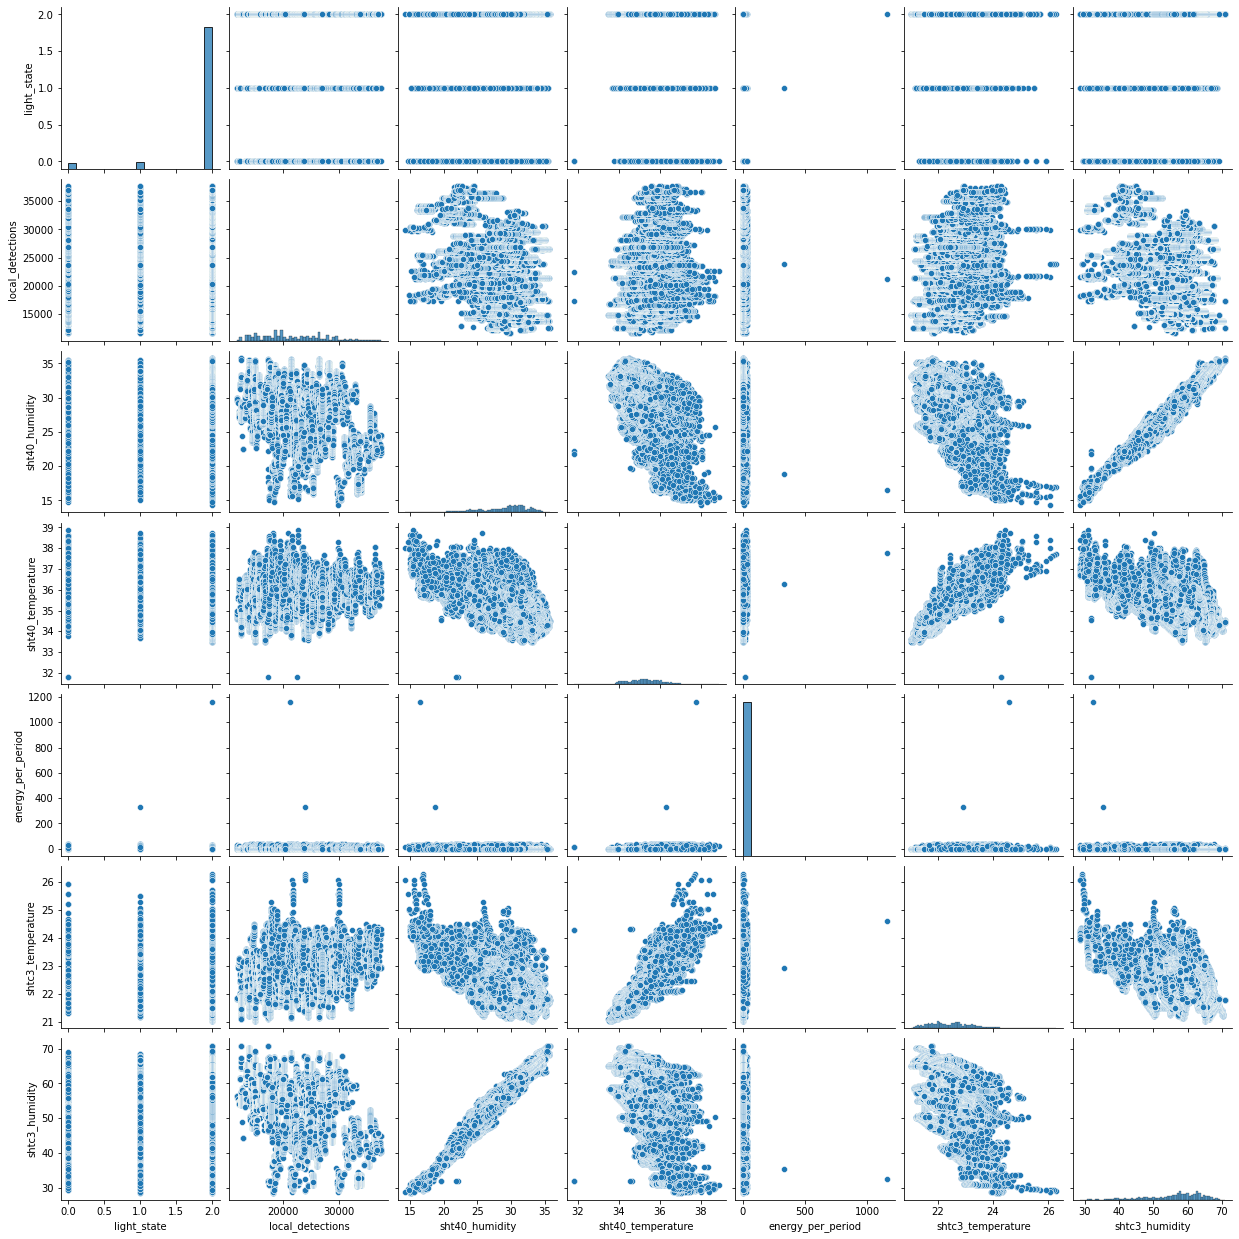

In [24]:
sns.pairplot(dflocsec[["light_state", "local_detections", "sht40_humidity", "sht40_temperature", "energy_per_period", "shtc3_temperature", "shtc3_humidity"]])

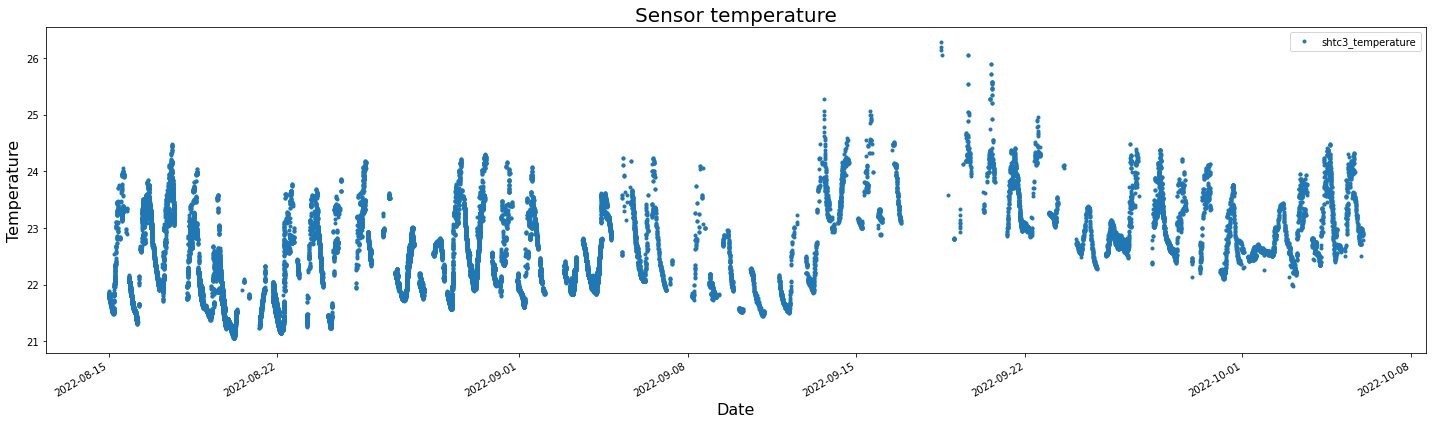

In [25]:
# trend of sensor temperature from the first dataset
fig, ax = plt.subplots(figsize=(20,6))
dflocsec.plot(x="time_x", y="shtc3_temperature", marker=".", linestyle="", ax=ax)
ax.set_title("Sensor temperature", size=20)
ax.set_xlabel("Date", size=16)
ax.set_ylabel("Temperature", size=16)

plt.tight_layout()
plt.show()


From the above, there are two distinct trends before and after 2022-09-14

## Generate dummy variables to examine whether the results are different for different subgroups

In [26]:
# define a function for one-hot-encoding categorical feature
def one_hot(df, feature, pref):
    dummies = pd.get_dummies(df[[feature]], prefix=pref, drop_first=True)
    res = pd.concat([df, dummies], axis=1)
    res = res.drop([feature], axis=1)
    return res 

In [27]:
# dummy variable to capture whether a reading is before of after 2022-09-14
dflocsec["dperiod"] = np.where(dflocsec["time_x"] > pd.Timestamp("2022-09-14"), 1, 0)

# dummy variable to capture whether a reading is on a weekend
dflocsec["dwkend"] = np.where(dflocsec["time_x"].dt.dayofweek > 4, 1, 0)

# dummy variable to capture whether a reading is at night (between midnight and 6am)
dflocsec["dnight"] = np.where((dflocsec["time_x"].dt.hour >= 0) & (dflocsec["time_x"].dt.hour <= 6), 1, 0)

# dummy variable for every lamp and sensor (except the first lamp and sensor to prevent multicollinearity when running regression)
dflocsec = one_hot(dflocsec, "source_address_x", "dl")
dflocsec = one_hot(dflocsec, "source_address_y", "ds")

In [28]:
dflocsec

time_x  light_state  local_detections  sht40_humidity  \
0     2022-08-15 05:40:51.143          1.0           18575.0           30.27   
1     2022-08-15 05:41:51.139          1.0           18577.0           30.08   
2     2022-08-15 05:42:51.151          2.0           18577.0           30.07   
3     2022-08-15 05:43:51.163          1.0           18577.0           30.14   
4     2022-08-15 05:44:51.163          2.0           18577.0           30.22   
...                       ...          ...               ...             ...   
39086 2022-10-04 15:09:53.728          1.0           20235.0           22.25   
39087 2022-10-04 15:14:53.775          0.0           20243.0           22.26   
39088 2022-10-04 21:10:43.383          2.0           20253.0           23.52   
39089 2022-10-05 23:05:48.051          2.0           20367.0           23.79   
39090 2022-10-05 23:35:50.843          2.0           20367.0           23.79   

       sht40_temperature  total_normalized_energy  wsen_pads_temperature  \
0                  35.10                 189758.0                  36.06   
1                  35.25                 189778.0                  36.18   
2                  35.22                 189779.0                  36.16   
3                  35.19                 189782.0                  36.19   
4                  35.24                 189782.0                  36.18   
...                  ...                      ...                    ...   
39086              37.15                 251498.0                  37.37   
39087              37.26                 251563.0                  37.47   
39088              35.88                 251725.0                  36.09   
39089              35.85                 254176.0                  36.07   
39090              35.79                 254184.0                  36.04   

       x_position_x  energy_per_period  detect_per_period  ...  dl_2050868026  \
0               111                1.0                0.0  ...              0   
1               111               20.0                2.0  ...              0   
2               111                1.0                0.0  ...              0   
3               111                3.0                0.0  ...              0   
4               111                0.0                0.0  ...              0   
...             ...                ...                ...  ...            ...   
39086           259               14.0                2.0  ...              0   
39087           259               34.0                8.0  ...              0   
39088           259                0.0                0.0  ...              0   
39089           259                0.0                0.0  ...              0   
39090           259                0.0                0.0  ...              0   

       dl_2062404276 ds_926036168  ds_1012045058  ds_1566931549  \
0                  1            0              0              0   
1                  1            0              0              0   
2                  1            0              0              0   
3                  1            0              0              0   
4                  1            0              0              0   
...              ...          ...            ...            ...   
39086              0            0              0              0   
39087              0            0              0              0   
39088              0            0              0              0   
39089              0            0              0              0   
39090              0            0              0              0   

       ds_1786944289  ds_1815204248  ds_1916751226  ds_2099571705  \
0                  0              0              1              0   
1                  0              0              1              0   
2                  0              0              1              0   
3                  0              0              1              0   
4                  0      

# Multiple Linear Regression
## Model Assessment
### Split the data into a train and test set.
### Run a multiple linear regression to predict the true ambient temperature. For the assessment, 10% of the train data of the first train-test split is kept as a validation set.

In [29]:
# define a function to run train-test split, regression, and evaluate the prediction
def reg_eval(df, features, target, printr2):
    X_train_full, X_test, y_train_full, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=18)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=18)
    X_train.shape, X_val.shape, y_train.shape, y_val.shape
    
    # initialize object \ instance of StandardScaler class
    ss = StandardScaler() 

    # first do fit -> compute mean and standard dev. for each feature of train data 
    # then do transform -> scale each feature, X_scaled = (X - mean) / sd
    X_train_scaled = ss.fit_transform(X_train) 

    # scale validation and test data based on learned parameters from train data (do not fit the validation and test data)
    # this means using the mean and sd from the training data for the standardization of the validation and test data
    X_val_scaled = ss.transform(X_val)

    #regr = LGBMRegressor()
    #regr = RandomForestRegressor()
    regr = LinearRegression()
    regr.fit(X_train_scaled, y_train.values.ravel())
    pred = regr.predict(X_val_scaled)
    rmse = np.sqrt(metrics.mean_squared_error(y_val, pred))
    r2 = metrics.r2_score(y_val, pred)

    if printr2:
        print(f"The X features included are {features} and the y target is {target}")
        print(f"RMSE: {rmse}")
        print(f"R2 Score: {r2}")
        return ss, regr
    else:
        return r2

In [30]:
# Model 1a: basic model with only lamp temperature, lamp humidity, and energy release
features = ["sht40_temperature", "sht40_humidity", "power"]
target = ["shtc3_temperature"]
scaler1a, model1a = reg_eval(dflocsec, features, target, printr2=True)

The X features included are ['sht40_temperature', 'sht40_humidity', 'power'] and the y target is ['shtc3_temperature']
RMSE: 0.30388828667978435
R2 Score: 0.8285899659005342


In [31]:
# Model 1b: basic model with only lamp temperature, lamp humidity, and energy release
features = ["sht40_temperature", "sht40_humidity", "power"]
target = ["shtc3_humidity"]
scaler1b, model1b = reg_eval(dflocsec, features, target, printr2=True)

The X features included are ['sht40_temperature', 'sht40_humidity', 'power'] and the y target is ['shtc3_humidity']
RMSE: 1.5405050093414514
R2 Score: 0.9677417476055838


In [32]:
# Model 2: Model 1a with dummies for period after 2022-09-14, weekend, and night
features = ["sht40_temperature", "sht40_humidity", "power", "dperiod", "dwkend", "dnight"]
target = ["shtc3_temperature"]
scaler2, model2 = reg_eval(dflocsec, features, target, printr2=True)

The X features included are ['sht40_temperature', 'sht40_humidity', 'power', 'dperiod', 'dwkend', 'dnight'] and the y target is ['shtc3_temperature']
RMSE: 0.28384419503156005
R2 Score: 0.8504562201268687


In [33]:
# Model 3: Model 2 with individual dummies for lamps and sensors
features = ["sht40_temperature", "sht40_humidity", "power", "dperiod", "dwkend", "dnight","dl_362609437", "dl_367818600", "dl_465407368", "dl_730804714", "dl_856134660", "dl_924241205", "dl_1307336718", "dl_1629094469", "dl_2050868026", "dl_2062404276", "ds_926036168", "ds_1012045058", "ds_1786944289", "ds_1815204248", "ds_1916751226", "ds_2099571705", "ds_2132706098"]
target = ["shtc3_temperature"]
scaler3, model3 = reg_eval(dflocsec, features, target, printr2=True)

The X features included are ['sht40_temperature', 'sht40_humidity', 'power', 'dperiod', 'dwkend', 'dnight', 'dl_362609437', 'dl_367818600', 'dl_465407368', 'dl_730804714', 'dl_856134660', 'dl_924241205', 'dl_1307336718', 'dl_1629094469', 'dl_2050868026', 'dl_2062404276', 'ds_926036168', 'ds_1012045058', 'ds_1786944289', 'ds_1815204248', 'ds_1916751226', 'ds_2099571705', 'ds_2132706098'] and the y target is ['shtc3_temperature']
RMSE: 0.2568797851095523
R2 Score: 0.8775191536724227


In [34]:
# save the scaler to disk - temperature
scalerfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_scaler_t.sav"
pickle.dump(scaler1a, open(scalerfile, "wb"))
# save the model to disk - temperature
modelfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_model_t.sav"
pickle.dump(model1a, open(modelfile, "wb"))

# save the scaler to disk - humidity
scalerfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_scaler_h.sav"
pickle.dump(scaler1b, open(scalerfile, "wb"))
# save the model to disk - humidity
modelfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_model_h.sav"
pickle.dump(model1b, open(modelfile, "wb"))

In [35]:
# load the scaler from disk
scalerfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_scaler_t.sav"
loaded_scaler = pickle.load(open(scalerfile, "rb"))

# load the model from disk
modelfile = "/content/drive/MyDrive/propulsion/Final_Project/saved_model_t.sav"
loaded_model = pickle.load(open(modelfile, "rb"))

# prepare the dataset
features = ["sht40_temperature", "sht40_humidity", "power"]
X_train_full, X_test, y_train_full, y_test = train_test_split(dflocsec[features], dflocsec[["shtc3_temperature"]], test_size=0.2, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=18)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# standardize the dataset using loaded scaler
X_test_scaled = loaded_scaler.transform(X_test)

# run the prediction using loaded model
l_pred = loaded_model.predict(X_test_scaled)
l_rmse = np.sqrt(metrics.mean_squared_error(y_test, l_pred))
l_r2 = metrics.r2_score(y_test, l_pred)
print(f"RMSE: {l_rmse}")
print(f"R2 Score: {l_r2}")



RMSE: 0.31419136415256593
R2 Score: 0.8240099840569032


In [39]:
# examine the R2 for the basic model (Model 1a) and including the dummies one by one
ind_features = ["dperiod", "dwkend", "dnight","dl_362609437", "dl_367818600", "dl_465407368", "dl_730804714", "dl_856134660", "dl_924241205", "dl_1307336718", "dl_1629094469", "dl_2050868026", "dl_2062404276", "ds_926036168", "ds_1012045058", "ds_1786944289", "ds_1815204248", "ds_1916751226", "ds_2099571705", "ds_2132706098"]
target = ["shtc3_temperature"]

flist = []
rlist = []
for f in ind_features:
    r2 = reg_eval(dflocsec, ["sht40_temperature", "sht40_humidity", "power", f], target, printr2=False)
    flist.append(f)
    rlist.append(r2)
dummies_r2 = pd.DataFrame(
    {"dummy": flist,
     "r2": rlist
    })

In [40]:
dummies_r2

dummy        r2
0         dperiod  0.834005
1          dwkend  0.828682
2          dnight  0.842626
3    dl_362609437  0.828637
4    dl_367818600  0.829664
5    dl_465407368  0.829160
6    dl_730804714  0.835280
7    dl_856134660  0.829586
8    dl_924241205  0.828830
9   dl_1307336718  0.832389
10  dl_1629094469  0.828621
11  dl_2050868026  0.853109
12  dl_2062404276  0.828596
13   ds_926036168  0.829110
14  ds_1012045058  0.828651
15  ds_1786944289  0.829586
16  ds_1815204248  0.832389
17  ds_1916751226  0.828596
18  ds_2099571705  0.853109
19  ds_2132706098  0.835998

In [41]:
# examine the R2 for the basic model (Model 1a) when only the subset data of each (dummy==1) is used 
ind_features = ["dperiod", "dwkend", "dnight","dl_362609437", "dl_367818600", "dl_465407368", "dl_730804714", "dl_856134660", "dl_924241205", "dl_1307336718", "dl_1629094469", "dl_2050868026", "dl_2062404276", "ds_926036168", "ds_1012045058", "ds_1786944289", "ds_1815204248", "ds_1916751226", "ds_2099571705", "ds_2132706098"]
target = ["shtc3_temperature"]

flist = []
rlist = []
for f in ind_features:
    dfpart = dflocsec[dflocsec[f]==1]
    r2 = reg_eval(dfpart, ["sht40_temperature", "sht40_humidity", "power"], target, printr2=False)
    flist.append(f)
    rlist.append(r2)
dummies1_subset_r2 = pd.DataFrame(
    {"dummy": flist,
     "r2": rlist
    })

In [42]:
dummies1_subset_r2

dummy        r2
0         dperiod  0.717275
1          dwkend  0.855906
2          dnight  0.766803
3    dl_362609437  0.887668
4    dl_367818600  0.918816
5    dl_465407368  0.861651
6    dl_730804714  0.903981
7    dl_856134660  0.916846
8    dl_924241205  0.961929
9   dl_1307336718  0.907932
10  dl_1629094469  0.936727
11  dl_2050868026  0.858803
12  dl_2062404276  0.837176
13   ds_926036168  0.868088
14  ds_1012045058  0.924085
15  ds_1786944289  0.916846
16  ds_1815204248  0.907932
17  ds_1916751226  0.837176
18  ds_2099571705  0.858803
19  ds_2132706098  0.890270

In [44]:
# examine the R2 for the basic model (Model 1a) when only the subset data of each (dummy==0) is used 
ind_features = ["dperiod", "dwkend", "dnight"]
target = ["shtc3_temperature"]

flist = []
rlist = []
for f in ind_features:
    dfpart = dflocsec[dflocsec[f]==0]
    r2 = reg_eval(dfpart, ["sht40_temperature", "sht40_humidity", "power"], target, printr2=False)
    flist.append(f)
    rlist.append(r2)
dummies0_subset_r2 = pd.DataFrame(
    {"dummy": flist,
     "r2": rlist
    })

In [45]:
dummies0_subset_r2

dummy        r2
0  dperiod  0.804580
1   dwkend  0.806016
2   dnight  0.791922

Summary findings:
  - When training and testing on only one lamp or one sensor, the R2 differs quite a bit (ranging from 0.83 to 0.96 for lamps and from 0.84 to 0.92 for sensors), indicating that there are differences between the lamps and sensors and they do not behave the same.
  - When training and testing using only reading from weekend or at night, time when it is expected to have less influence from external factors such as human presence, the R2 is also only between 0.77 - 0.86, indicating that the devices do not behave uniformly as expected. 

### Perform a k-Fold cross-validation on the whole train dataset from the first split with k = 10. This requires the following steps:

  - Build a pipeline for the feature scaling.
  - Use the function cross_val_score from scikit-learn. The function takes as an argument the desired scoring metric. For the linear regression use R2

In [46]:
features = ["sht40_temperature", "sht40_humidity", "power"]
X_train_full, X_test, y_train_full, y_test = train_test_split(dflocsec[features], dflocsec[["shtc3_temperature"]], test_size=0.2, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=18)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((28144, 3), (3128, 3), (28144, 1), (3128, 1))

In [47]:
pipeline = Pipeline(steps = [("standard_scale", StandardScaler()),
                              ("modeling", LinearRegression())])

scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="r2")
scores

array([0.83144525, 0.83149836, 0.83027284, 0.80632421, 0.82821889,
       0.83695016, 0.82285705, 0.82964079, 0.84347586, 0.82253964])

In [48]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

print("R2 Score", metrics.r2_score(y_test, pred))


R2 Score 0.8240099840569032


### Perform a polynomial regression of features with degrees 2, 3 and 4 and compare the results.


In [49]:
# 2 Degrees
# initialize
poly_feat2 = PolynomialFeatures(degree=2, include_bias=False)
# fit and transform
X_poly2_train = poly_feat2.fit_transform(X_train)
X_poly2_test = poly_feat2.transform(X_test) # do not fit for test data
# run regression and predict
regr2 = LinearRegression()
regr2.fit(X_poly2_train, y_train)
pred2 = regr2.predict(X_poly2_test)

# 3 Degrees
# initialize
poly_feat3 = PolynomialFeatures(degree=3, include_bias=False)
# fit and transform
X_poly3_train = poly_feat3.fit_transform(X_train)
X_poly3_test = poly_feat3.transform(X_test) # do not fit for test data
# run regression and predict
regr3 = LinearRegression()
regr3.fit(X_poly3_train, y_train)
pred3 = regr3.predict(X_poly3_test)

# 4 Degrees
# initialize
poly_feat4 = PolynomialFeatures(degree=4, include_bias=False)
# fit and transform
X_poly4_train = poly_feat4.fit_transform(X_train)
X_poly4_test = poly_feat4.transform(X_test) # do not fit for test data
# run regression and predict
regr4 = LinearRegression()
regr4.fit(X_poly4_train, y_train)
pred4 = regr4.predict(X_poly4_test)

In [50]:
print("degree 1:")
print("MAE", metrics.mean_absolute_error(y_test, pred))
print("MSE", metrics.mean_squared_error(y_test, pred))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("R2 Score", metrics.r2_score(y_test, pred))

print("degree 2:")
print("MAE", metrics.mean_absolute_error(y_test, pred2))
print("MSE", metrics.mean_squared_error(y_test, pred2))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, pred2)))
print("R2 Score", metrics.r2_score(y_test, pred2))

print("degree 3:")
print("MAE", metrics.mean_absolute_error(y_test, pred3))
print("MSE", metrics.mean_squared_error(y_test, pred3))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, pred3)))
print("R2 Score", metrics.r2_score(y_test, pred3))

print("degree 4:")
print("MAE", metrics.mean_absolute_error(y_test, pred4))
print("MSE", metrics.mean_squared_error(y_test, pred4))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, pred4)))
print("R2 Score", metrics.r2_score(y_test, pred4))

degree 1:
MAE 0.23432448451431734
MSE 0.09871621330805029
RMSE 0.31419136415256593
R2 Score 0.8240099840569032
degree 2:
MAE 0.23014385308463287
MSE 0.0941062442654588
RMSE 0.3067674106965386
R2 Score 0.8322285785320693
degree 3:
MAE 0.2254902839995143
MSE 0.08867325728435885
RMSE 0.2977805522265664
R2 Score 0.8419144389736433
degree 4:
MAE 0.223784946937914
MSE 0.08711905345415633
RMSE 0.29515936958557887
R2 Score 0.8446852538954293


Degree 3 and 4 provide better R2 but it could also be overfitting the data

### Try different methods for scaling, e.g., StandardScaler and MinMaxScaler.

In [51]:
pipeline = Pipeline(steps = [("standard_scale", StandardScaler()),
                              ("modeling", LinearRegression())])

scores_st = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="r2")

pipeline2 = Pipeline(steps = [("minmax_scale", MinMaxScaler()),
                              ("modeling", LinearRegression())])

scores_mm = cross_val_score(pipeline2, X_train, y_train, cv=10, scoring="r2")

scores_st.mean(), scores_mm.mean()

(0.8283223059133963, 0.8283223059133965)

There is not much difference between the two methods.

## Implement the model to find out the individual coefficients and significance

In [52]:
# initialize object \ instance of StandardScaler class
ss = StandardScaler() 

# first do fit -> compute mean and standard dev. for each feature of data 
# then do transform -> scale each feature, X_scaled = (X - mean) / sd
df_feature = dflocsec[["sht40_humidity", "sht40_temperature", "power", "dperiod", "dwkend", "dnight", "x_position_x", "x_position_y", "local_detections", "time_diff"]]
X_scaled = ss.fit_transform(df_feature)
df_scaled = pd.DataFrame(X_scaled, index=df_feature.index, columns=df_feature.columns)

In [53]:
y = dflocsec["shtc3_temperature"]
X = sm.add_constant(df_scaled[["sht40_temperature"]])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      shtc3_temperature   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.782e+05
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:12:14   Log-Likelihood:                -10378.
No. Observations:               39091   AIC:                         2.076e+04
Df Residuals:                   39089   BIC:                         2.078e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.4589      0.00

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
y = dflocsec["shtc3_temperature"]
X = sm.add_constant(df_scaled[["sht40_temperature", "power"]])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      shtc3_temperature   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 8.928e+04
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:18:21   Log-Likelihood:                -10347.
No. Observations:               39091   AIC:                         2.070e+04
Df Residuals:                   39088   BIC:                         2.073e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.4589      0.00

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
y = dflocsec["shtc3_temperature"]
X = sm.add_constant(df_scaled[["sht40_temperature", "power", "sht40_humidity"]])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      shtc3_temperature   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 6.257e+04
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:18:32   Log-Likelihood:                -9540.8
No. Observations:               39091   AIC:                         1.909e+04
Df Residuals:                   39087   BIC:                         1.912e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.4589      0.00

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
y = dflocsec["shtc3_temperature"]
X = sm.add_constant(df_scaled[["sht40_temperature", "power", "sht40_humidity", "dperiod"]])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      shtc3_temperature   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 4.973e+04
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:18:37   Log-Likelihood:                -8599.1
No. Observations:               39091   AIC:                         1.721e+04
Df Residuals:                   39086   BIC:                         1.725e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.4589      0.00

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Summary findings:
  - Main feature capturing the changes in sensor temperature is lamp temperature.
  - This second important feature is whether the reading is taken before or after 2022-09-14. So, something happened in the room after 2022-09-14 that is not captured by the features available in the dataset.
  - Power and humidity do not seem to capture much the changes in sensor temperature.

## Regress on the difference between lamp and sensor

In [57]:
# generate two new features (difference in temperature between lamp and sensor and absolute difference)
dflocsec["tempdiff"] = dflocsec["sht40_temperature"] - dflocsec["shtc3_temperature"]

In [58]:
y = dflocsec["tempdiff"]
X = X = sm.add_constant(df_scaled[["sht40_humidity", "power", "dperiod", "dwkend", "dnight"]])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               tempdiff   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     643.1
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:20:34   Log-Likelihood:                -14958.
No. Observations:               39091   AIC:                         2.993e+04
Df Residuals:                   39085   BIC:                         2.998e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.8643      0.002   7168.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Summary findings:
  - Humidity reading from the lamp and the period after 2022-09-14 capture the difference in temperature between the lamp and sensor readings the best.
  - Even though weekend and night show a reduction in the difference in temperature readings (indicating that human presence does lead to an increase in the difference in readings of temperature by the lamp and sensor), the reduction is relatively small.
  - Overall, the features available in the dataset and features such as period after 2022-09-04, weekend, and night do not capture much of the difference in temperature readings between lamp and sensor (R2 is only 0.076), indicating that there are some other external factors that are causing the difference in readings.